<a href="https://colab.research.google.com/github/mdsiam135/thesis_2025/blob/main/KNN(3_labels).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
# =============================================================================
# STEP-BY-STEP KNN AGRICULTURAL PRODUCTION CLASSIFICATION MODEL - FIXED
# =============================================================================

# =============================================================================
# STEP 1: IMPORT REQUIRED LIBRARIES
# =============================================================================
print("🔧 STEP 1: Importing Required Libraries...")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score,
    precision_score, recall_score, f1_score, log_loss
)
from sklearn.model_selection import cross_val_score, GridSearchCV
import warnings
warnings.filterwarnings('ignore')

# Set matplotlib style for better plots
plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 5)
plt.rcParams['font.size'] = 10

print("✅ Libraries imported successfully!")



🔧 STEP 1: Importing Required Libraries...
✅ Libraries imported successfully!


In [22]:

# =============================================================================
# STEP 2: DEFINE CONFIGURATION PARAMETERS
# =============================================================================
print("\n⚙️ STEP 2: Setting Configuration Parameters...")

# Model parameters - we'll find the best k through grid search
K_RANGE = range(3, 21, 2)  # Test k values from 3 to 19 (odd numbers work better)
RANDOM_SEED = 42           # For reproducibility

# File paths (modify these according to your file locations)
TRAIN_PATH = '/content/drive/MyDrive/UpdatedDataset/train.csv'
VALIDATION_PATH = '/content/drive/MyDrive/UpdatedDataset/validation.csv'
TEST_PATH = '/content/drive/MyDrive/UpdatedDataset/test.csv'

# Alternative paths (update according to your actual file location)
ALT_TRAIN_PATH = '/content/drive/MyDrive/Yearbook of Agricultural Statistics/train.csv'
ALT_VALIDATION_PATH = '/content/drive/MyDrive/Yearbook of Agricultural Statistics/validation.csv'
ALT_TEST_PATH = '/content/drive/MyDrive/Yearbook of Agricultural Statistics/test.csv'

# Set random seed for reproducibility
np.random.seed(RANDOM_SEED)

print(f"✅ Configuration set - K range: {list(K_RANGE)}")



⚙️ STEP 2: Setting Configuration Parameters...
✅ Configuration set - K range: [3, 5, 7, 9, 11, 13, 15, 17, 19]


In [23]:

# =============================================================================
# STEP 3: DEFINE HELPER FUNCTIONS
# =============================================================================
print("\n🛠️ STEP 3: Defining Helper Functions...")

def calculate_loss(y_true, y_pred_proba):
    """Calculate cross-entropy loss for KNN model"""
    epsilon = 1e-15
    y_pred_proba = np.clip(y_pred_proba, epsilon, 1 - epsilon)
    loss = log_loss(y_true, y_pred_proba)
    return loss

def create_production_labels(df_list):
    """Create categorical labels (low, medium, high) based on production values"""
    # Combine all production values to determine thresholds
    all_production = pd.concat([df['Production (M.Ton)'] for df in df_list])

    # Define thresholds using quantiles
    low_threshold = np.percentile(all_production, 33.33)
    high_threshold = np.percentile(all_production, 66.67)

    print(f"📊 Production thresholds:")
    print(f"   Low: < {low_threshold:.2f}")
    print(f"   Medium: {low_threshold:.2f} - {high_threshold:.2f}")
    print(f"   High: > {high_threshold:.2f}")

    # Create labels for each dataset
    for df in df_list:
        df['Production_Label'] = pd.cut(
            df['Production (M.Ton)'],
            bins=[-np.inf, low_threshold, high_threshold, np.inf],
            labels=['low', 'medium', 'high']
        )

    return df_list

print("✅ Helper functions defined!")




🛠️ STEP 3: Defining Helper Functions...
✅ Helper functions defined!


In [24]:

# =============================================================================
# STEP 4: LOAD AND EXPLORE DATA
# =============================================================================
print("\n📂 STEP 4: Loading and Exploring Data...")

# Try loading from primary path first, then alternative
try:
    print("Trying primary file paths...")
    train_df = pd.read_csv(TRAIN_PATH)
    val_df = pd.read_csv(VALIDATION_PATH)
    test_df = pd.read_csv(TEST_PATH)
    print("✅ Data loaded from primary paths!")
except FileNotFoundError:
    try:
        print("Primary paths not found, trying alternative paths...")
        train_df = pd.read_csv(ALT_TRAIN_PATH)
        val_df = pd.read_csv(ALT_VALIDATION_PATH)
        test_df = pd.read_csv(ALT_TEST_PATH)
        print("✅ Data loaded from alternative paths!")
    except FileNotFoundError as e:
        print(f"❌ Error loading files: {e}")
        print("Please ensure CSV files are in one of these locations:")
        print(f"   Primary: {TRAIN_PATH}")
        print(f"   Alternative: {ALT_TRAIN_PATH}")
        exit()

print(f"   Training set shape: {train_df.shape}")
print(f"   Validation set shape: {val_df.shape}")
print(f"   Test set shape: {test_df.shape}")

# Display basic info about the dataset
print(f"\n📈 Dataset Information:")
print(f"   Total features: {len(train_df.columns) - 1}")  # -1 for target column
print(f"   Production range: {train_df['Production (M.Ton)'].min():.2f} - {train_df['Production (M.Ton)'].max():.2f}")




📂 STEP 4: Loading and Exploring Data...
Trying primary file paths...
✅ Data loaded from primary paths!
   Training set shape: (3942, 84)
   Validation set shape: (845, 84)
   Test set shape: (845, 84)

📈 Dataset Information:
   Total features: 83
   Production range: 0.00 - 544979.50


In [25]:

# =============================================================================
# STEP 5: DATA PREPROCESSING
# =============================================================================
print("\n🔄 STEP 5: Data Preprocessing...")

# Create production labels
print("Creating production labels...")
train_df, val_df, test_df = create_production_labels([train_df, val_df, test_df])

# Prepare features (exclude target columns)
feature_columns = [col for col in train_df.columns
                  if col not in ['Production (M.Ton)', 'Production_Label']]

print(f"📊 Feature columns: {len(feature_columns)}")

# Extract features and labels
X_train = train_df[feature_columns]
X_val = val_df[feature_columns]
X_test = test_df[feature_columns]

y_train = train_df['Production_Label']
y_val = val_df['Production_Label']
y_test = test_df['Production_Label']

# Initialize encoders and scalers
label_encoder = LabelEncoder()
scaler = StandardScaler()

# Encode labels
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)
y_test_encoded = label_encoder.transform(y_test)

# Scale features
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Display label distribution
print(f"\n📊 Label Distribution:")
label_counts = pd.Series(y_train).value_counts()
for label, count in label_counts.items():
    print(f"   {label}: {count} samples ({count/len(y_train)*100:.1f}%)")

print("✅ Data preprocessing completed!")



🔄 STEP 5: Data Preprocessing...
Creating production labels...
📊 Production thresholds:
   Low: < 1095.00
   Medium: 1095.00 - 4019.00
   High: > 4019.00
📊 Feature columns: 83

📊 Label Distribution:
   low: 1317 samples (33.4%)
   medium: 1315 samples (33.4%)
   high: 1310 samples (33.2%)
✅ Data preprocessing completed!


In [12]:

# =============================================================================
# STEP 6: HYPERPARAMETER TUNING (FINDING OPTIMAL K)
# =============================================================================
print("\n🔍 STEP 6: Finding Optimal K Value...")

# Test different k values
k_scores = []
k_val_scores = []

print("Testing different k values...")
print("-" * 50)

for k in K_RANGE:
    # Create and train KNN model
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_scaled, y_train_encoded)

    # Calculate training accuracy
    train_pred = knn.predict(X_train_scaled)
    train_accuracy = accuracy_score(y_train_encoded, train_pred)

    # Calculate validation accuracy
    val_pred = knn.predict(X_val_scaled)
    val_accuracy = accuracy_score(y_val_encoded, val_pred)

    k_scores.append(train_accuracy)
    k_val_scores.append(val_accuracy)

    print(f"k={k:2d}: Train Accuracy = {train_accuracy:.4f}, Val Accuracy = {val_accuracy:.4f}")

# Find optimal k
best_k_idx = np.argmax(k_val_scores)
best_k = list(K_RANGE)[best_k_idx]
best_val_accuracy = k_val_scores[best_k_idx]

print("-" * 50)
print(f"✅ Optimal k value: {best_k} (Validation Accuracy: {best_val_accuracy:.4f})")



🔍 STEP 6: Finding Optimal K Value...
Testing different k values...
--------------------------------------------------
k= 3: Train Accuracy = 0.9472, Val Accuracy = 0.8852
k= 5: Train Accuracy = 0.9267, Val Accuracy = 0.8663
k= 7: Train Accuracy = 0.9087, Val Accuracy = 0.8604
k= 9: Train Accuracy = 0.9008, Val Accuracy = 0.8473
k=11: Train Accuracy = 0.8962, Val Accuracy = 0.8473
k=13: Train Accuracy = 0.8838, Val Accuracy = 0.8296
k=15: Train Accuracy = 0.8656, Val Accuracy = 0.8083
k=17: Train Accuracy = 0.8349, Val Accuracy = 0.7645
k=19: Train Accuracy = 0.8123, Val Accuracy = 0.7349
--------------------------------------------------
✅ Optimal k value: 3 (Validation Accuracy: 0.8852)



📊 STEP 7: Plotting K-Value Analysis...


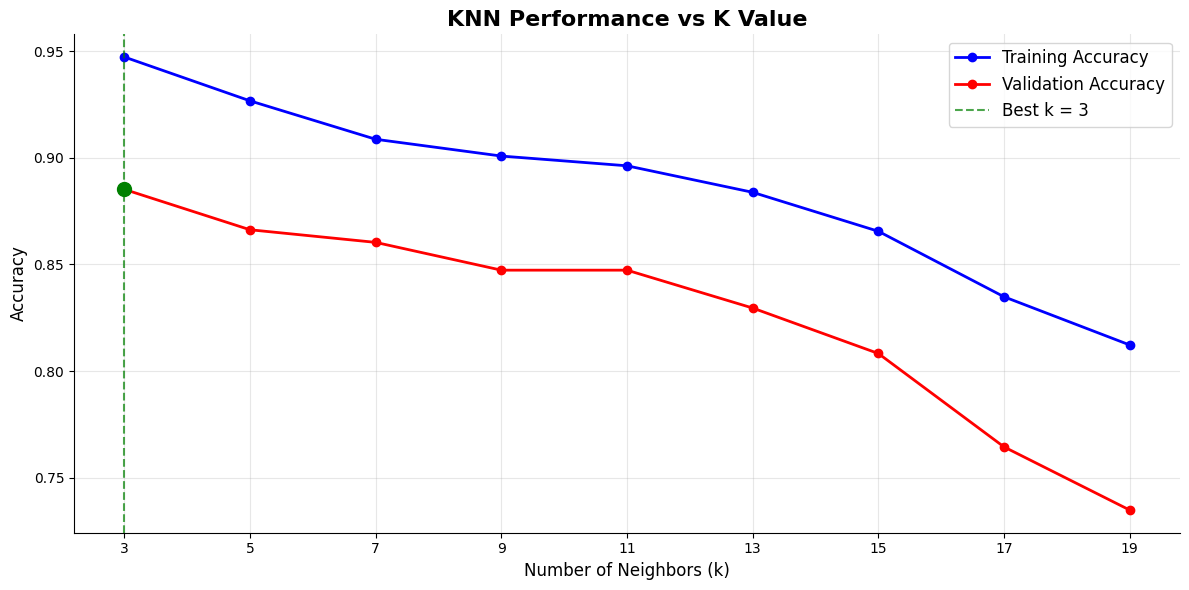

In [13]:

# =============================================================================
# STEP 7: PLOT K-VALUE ANALYSIS
# =============================================================================
print("\n📊 STEP 7: Plotting K-Value Analysis...")

def plot_k_analysis(k_range, train_scores, val_scores, best_k):
    """Plot the effect of different k values on model performance"""
    plt.figure(figsize=(12, 6))

    plt.plot(k_range, train_scores, 'b-o', linewidth=2, markersize=6, label='Training Accuracy')
    plt.plot(k_range, val_scores, 'r-o', linewidth=2, markersize=6, label='Validation Accuracy')

    # Highlight best k
    plt.axvline(x=best_k, color='green', linestyle='--', alpha=0.7,
                label=f'Best k = {best_k}')
    plt.scatter([best_k], [val_scores[list(k_range).index(best_k)]],
                color='green', s=100, zorder=5)

    plt.title('KNN Performance vs K Value', fontsize=16, fontweight='bold')
    plt.xlabel('Number of Neighbors (k)', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.xticks(k_range)

    # Styling
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)

    plt.tight_layout()
    plt.show()

# Generate k-value analysis plot
plot_k_analysis(K_RANGE, k_scores, k_val_scores, best_k)


In [14]:

# =============================================================================
# STEP 8: TRAIN FINAL MODEL WITH OPTIMAL K
# =============================================================================
print(f"\n🤖 STEP 8: Training Final Model with k={best_k}...")

# Initialize and train the final model with optimal k
final_knn_model = KNeighborsClassifier(n_neighbors=best_k)
final_knn_model.fit(X_train_scaled, y_train_encoded)

print(f"✅ Final KNN model trained with k={best_k}")



🤖 STEP 8: Training Final Model with k=3...
✅ Final KNN model trained with k=3


In [15]:

# =============================================================================
# STEP 9: CROSS-VALIDATION ANALYSIS
# =============================================================================
print("\n🔄 STEP 9: Performing Cross-Validation Analysis...")

# Perform 5-fold cross-validation
cv_scores = cross_val_score(final_knn_model, X_train_scaled, y_train_encoded,
                           cv=5, scoring='accuracy')

print(f"📊 5-Fold Cross-Validation Results:")
print(f"   CV Scores: {[f'{score:.4f}' for score in cv_scores]}")
print(f"   Mean CV Score: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")



🔄 STEP 9: Performing Cross-Validation Analysis...
📊 5-Fold Cross-Validation Results:
   CV Scores: ['0.8771', '0.8859', '0.8947', '0.8756', '0.9036']
   Mean CV Score: 0.8874 (+/- 0.0212)


In [16]:

# =============================================================================
# STEP 10: DEFINE EVALUATION FUNCTIONS
# =============================================================================
print("\n📏 STEP 10: Defining Evaluation Functions...")

def evaluate_model(model, X, y, dataset_name):
    """Comprehensive model evaluation"""
    predictions = model.predict(X)
    pred_proba = model.predict_proba(X)

    # Calculate all metrics
    accuracy = accuracy_score(y, predictions)
    precision_macro = precision_score(y, predictions, average='macro', zero_division=0)
    recall_macro = recall_score(y, predictions, average='macro', zero_division=0)
    f1_macro = f1_score(y, predictions, average='macro', zero_division=0)

    precision_weighted = precision_score(y, predictions, average='weighted', zero_division=0)
    recall_weighted = recall_score(y, predictions, average='weighted', zero_division=0)
    f1_weighted = f1_score(y, predictions, average='weighted', zero_division=0)

    # Calculate loss
    loss = calculate_loss(y, pred_proba)

    results = {
        'Dataset': dataset_name,
        'Accuracy': accuracy,
        'Precision (Macro)': precision_macro,
        'Recall (Macro)': recall_macro,
        'F1 Score (Macro)': f1_macro,
        'Precision (Weighted)': precision_weighted,
        'Recall (Weighted)': recall_weighted,
        'F1 Score (Weighted)': f1_weighted,
        'Loss': loss
    }

    return results, predictions

def plot_confusion_matrix(y_true, y_pred, dataset_name, label_encoder):
    """Plot enhanced confusion matrix"""
    plt.figure(figsize=(6, 4))
    cm = confusion_matrix(y_true, y_pred)
    labels = label_encoder.classes_

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar_kws={'shrink': 0.8},
               xticklabels=labels, yticklabels=labels, square=True,
               linewidths=0.5, annot_kws={'size': 12})

    plt.title(f'Confusion Matrix - {dataset_name}', fontsize=16, fontweight='bold', pad=20)
    plt.xlabel('Predicted', fontsize=14)
    plt.ylabel('Actual', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12, rotation=0)
    plt.tight_layout()
    plt.show()

    # Print statistics
    total_samples = np.sum(cm)
    correct_predictions = np.trace(cm)
    print(f"\n📊 Confusion Matrix Statistics - {dataset_name}:")
    print(f"   Total Samples: {total_samples}")
    print(f"   Correct Predictions: {correct_predictions}")
    print(f"   Accuracy: {correct_predictions/total_samples:.4f}")

print("✅ Evaluation functions defined!")



📏 STEP 10: Defining Evaluation Functions...
✅ Evaluation functions defined!



🔍 STEP 11: Evaluating on Validation Set...
VALIDATION SET METRICS:
   Accuracy: 0.8852
   Precision (Macro): 0.8855
   Recall (Macro): 0.8860
   F1 Score (Macro): 0.8856
   Precision (Weighted): 0.8852
   Recall (Weighted): 0.8852
   F1 Score (Weighted): 0.8851
   Loss: 1.2918

📋 Detailed Classification Report - Validation:
              precision    recall  f1-score   support

        high       0.87      0.90      0.88       273
         low       0.94      0.93      0.94       281
      medium       0.85      0.83      0.84       291

    accuracy                           0.89       845
   macro avg       0.89      0.89      0.89       845
weighted avg       0.89      0.89      0.89       845



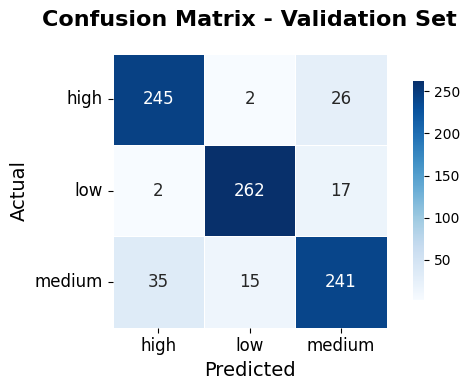


📊 Confusion Matrix Statistics - Validation Set:
   Total Samples: 845
   Correct Predictions: 748
   Accuracy: 0.8852


In [17]:

# =============================================================================
# STEP 11: VALIDATION SET EVALUATION
# =============================================================================
print("\n🔍 STEP 11: Evaluating on Validation Set...")
print("=" * 60)

val_results, val_predictions = evaluate_model(final_knn_model, X_val_scaled, y_val_encoded, "Validation")

print("VALIDATION SET METRICS:")
for metric, value in val_results.items():
    if metric != 'Dataset':
        print(f"   {metric}: {value:.4f}")

# Classification report
labels = label_encoder.classes_
val_report = classification_report(y_val_encoded, val_predictions, target_names=labels)
print(f"\n📋 Detailed Classification Report - Validation:")
print(val_report)

# Confusion matrix
plot_confusion_matrix(y_val_encoded, val_predictions, "Validation Set", label_encoder)



🎯 STEP 12: Evaluating on Test Set...
TEST SET METRICS:
   Accuracy: 0.8970
   Precision (Macro): 0.8973
   Recall (Macro): 0.8960
   F1 Score (Macro): 0.8964
   Precision (Weighted): 0.8977
   Recall (Weighted): 0.8970
   F1 Score (Weighted): 0.8971
   Loss: 0.8800

📋 Detailed Classification Report - Test:
              precision    recall  f1-score   support

        high       0.89      0.93      0.91       293
         low       0.95      0.92      0.93       280
      medium       0.85      0.84      0.85       272

    accuracy                           0.90       845
   macro avg       0.90      0.90      0.90       845
weighted avg       0.90      0.90      0.90       845



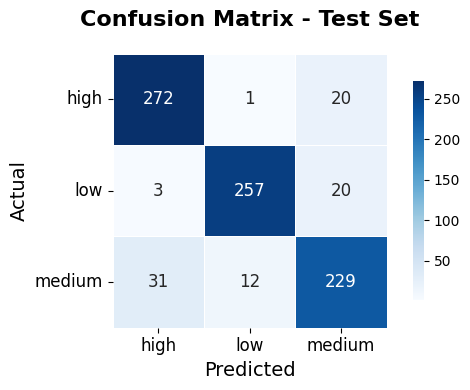


📊 Confusion Matrix Statistics - Test Set:
   Total Samples: 845
   Correct Predictions: 758
   Accuracy: 0.8970


In [18]:

# =============================================================================
# STEP 12: TEST SET EVALUATION
# =============================================================================
print("\n🎯 STEP 12: Evaluating on Test Set...")
print("=" * 60)

test_results, test_predictions = evaluate_model(final_knn_model, X_test_scaled, y_test_encoded, "Test")

print("TEST SET METRICS:")
for metric, value in test_results.items():
    if metric != 'Dataset':
        print(f"   {metric}: {value:.4f}")

# Classification report
test_report = classification_report(y_test_encoded, test_predictions, target_names=labels)
print(f"\n📋 Detailed Classification Report - Test:")
print(test_report)

# Confusion matrix
plot_confusion_matrix(y_test_encoded, test_predictions, "Test Set", label_encoder)


In [19]:

# =============================================================================
# STEP 13: FINAL RESULTS SUMMARY
# =============================================================================
print("\n📊 STEP 13: Final Results Summary...")
print("=" * 80)

# Create summary table
results_df = pd.DataFrame([val_results, test_results])
print("COMPREHENSIVE RESULTS COMPARISON:")
print(results_df.round(4).to_string(index=False))

# Key metrics highlight
print(f"\n🎯 KEY PERFORMANCE INDICATORS:")
print(f"   Optimal k value: {best_k}")
print(f"   Cross-validation score: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")
print(f"   Validation Accuracy: {val_results['Accuracy']:.4f}")
print(f"   Test Accuracy: {test_results['Accuracy']:.4f}")
print(f"   Validation Macro F1 Score: {val_results['F1 Score (Macro)']:.4f}")
print(f"   Test Macro F1 Score: {test_results['F1 Score (Macro)']:.4f}")

# Model performance analysis
print(f"\n📈 PERFORMANCE ANALYSIS:")
accuracy_drop = val_results['Accuracy'] - test_results['Accuracy']
f1_drop = val_results['F1 Score (Macro)'] - test_results['F1 Score (Macro)']

print(f"   Accuracy drop from validation to test: {accuracy_drop:.4f}")
print(f"   F1 score drop from validation to test: {f1_drop:.4f}")

if accuracy_drop > 0.05:
    print("   ⚠️  Possible overfitting detected (accuracy drop > 5%)")
else:
    print("   ✅ Good generalization (accuracy drop < 5%)")



📊 STEP 13: Final Results Summary...
COMPREHENSIVE RESULTS COMPARISON:
   Dataset  Accuracy  Precision (Macro)  Recall (Macro)  F1 Score (Macro)  Precision (Weighted)  Recall (Weighted)  F1 Score (Weighted)   Loss
Validation    0.8852             0.8855           0.886            0.8856                0.8852             0.8852               0.8851 1.2918
      Test    0.8970             0.8973           0.896            0.8964                0.8977             0.8970               0.8971 0.8800

🎯 KEY PERFORMANCE INDICATORS:
   Optimal k value: 3
   Cross-validation score: 0.8874 (+/- 0.0212)
   Validation Accuracy: 0.8852
   Test Accuracy: 0.8970
   Validation Macro F1 Score: 0.8856
   Test Macro F1 Score: 0.8964

📈 PERFORMANCE ANALYSIS:
   Accuracy drop from validation to test: -0.0118
   F1 score drop from validation to test: -0.0108
   ✅ Good generalization (accuracy drop < 5%)


In [20]:

# =============================================================================
# STEP 14: MODEL INFORMATION SUMMARY
# =============================================================================
print(f"\n💾 STEP 14: Model Information Summary...")

model_info = {
    'Model Type': 'K-Nearest Neighbors (KNN)',
    'Optimal Number of Neighbors': best_k,
    'Number of Features': len(feature_columns),
    'Number of Classes': len(label_encoder.classes_),
    'Classes': list(label_encoder.classes_),
    'Cross-Validation Score': f"{cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})",
    'Best Validation Accuracy': val_results['Accuracy'],
    'Final Test Accuracy': test_results['Accuracy'],
    'Final Test Macro F1': test_results['F1 Score (Macro)']
}

print("📋 MODEL SUMMARY:")
for key, value in model_info.items():
    print(f"   {key}: {value}")

print(f"\n✨ All steps completed successfully! ✨")
print(f"📊 Check the generated plots above for visual analysis.")
print(f"🎯 Your model achieved {test_results['Accuracy']:.1%} accuracy on the test set!")
print(f"🔍 The optimal k value found through validation is: {best_k}")

# =============================================================================
# ADDITIONAL: FEATURE IMPORTANCE ANALYSIS (Optional)
# =============================================================================
print(f"\n🔬 BONUS: Feature Analysis...")
print("Note: KNN doesn't provide feature importance directly, but we can analyze feature correlations.")

# Calculate correlation with target (using original production values)
feature_importance = []
for feature in feature_columns:
    correlation = abs(train_df[feature].corr(train_df['Production (M.Ton)']))
    feature_importance.append((feature, correlation))

# Sort by correlation
feature_importance.sort(key=lambda x: x[1], reverse=True)

print("📊 Top 10 Features by Correlation with Production:")
for i, (feature, corr) in enumerate(feature_importance[:10], 1):
    print(f"   {i:2d}. {feature}: {corr:.4f}")

print(f"\n🎉 KNN AGRICULTURAL PRODUCTION CLASSIFIER ANALYSIS COMPLETED! 🎉")


💾 STEP 14: Model Information Summary...
📋 MODEL SUMMARY:
   Model Type: K-Nearest Neighbors (KNN)
   Optimal Number of Neighbors: 3
   Number of Features: 83
   Number of Classes: 3
   Classes: ['high', 'low', 'medium']
   Cross-Validation Score: 0.8874 (+/- 0.0212)
   Best Validation Accuracy: 0.8852071005917159
   Final Test Accuracy: 0.8970414201183432
   Final Test Macro F1: 0.8964353872335443

✨ All steps completed successfully! ✨
📊 Check the generated plots above for visual analysis.
🎯 Your model achieved 89.7% accuracy on the test set!
🔍 The optimal k value found through validation is: 3

🔬 BONUS: Feature Analysis...
Note: KNN doesn't provide feature importance directly, but we can analyze feature correlations.
📊 Top 10 Features by Correlation with Production:
    1. Area (Acres): 0.9681
    2. Crop_Onion: 0.2830
    3. District_Pabna: 0.2397
    4. District_Faridpur: 0.1481
    5. District_Rajshahi: 0.1470
    6. District_Rajbari: 0.1265
    7. Temperature at 2 Meters Range (C